In [ ]:
pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import seaborn as sns
import math
import matplotlib.pyplot as plt
from joblib import dump, load
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from datetime import date
import glob, os
import time
import random
random.seed(42)
np.random.seed(42)
import lime
from lime import submodular_pick
from lime import lime_tabular
from collections import defaultdict

import xlsxwriter

from ipynb.fs.full.Data_Preparation import getProcessedData
from ipynb.fs.full.Data_Preparation import getFilenames
from ipynb.fs.full.Data_Preparation import getProcessedData_strategy
from ipynb.fs.full.Data_Preparation import getProcessedData_test

In [ ]:
path = os.getcwd()

In [ ]:
# Create a dictionary that defines the top 20 features for each currency ticker. These features are selected by SFFS
feat_20={
    'USDEUR': [0, 6, 11, 12, 16, 22, 23, 24, 25, 28, 30, 31, 33, 38, 44, 45, 48, 49, 54, 59],
    'USDJPY': [0, 13, 14, 15, 16, 18, 19, 20, 21, 22, 26, 28, 31, 33, 35, 38, 41, 47, 51, 53],
    'USDGBP': [1, 2, 5, 13, 16, 18, 23, 24, 25, 31, 35, 36, 38, 41, 42, 46, 48, 51, 52, 54],
    'USDCHF': [2, 5, 7, 8, 10, 11, 17, 25, 27, 35, 41, 43, 47, 48, 51, 52, 53, 54, 55, 57],
    'USDNZD': [5, 6, 8, 10, 13, 14, 17, 20, 21, 23, 24, 25, 33, 37, 40, 43, 51, 52, 53, 57],
    'USDCAD': [5, 8, 10, 11, 17, 18, 20, 23, 24, 25, 31, 33, 35, 40, 42, 52, 54, 55, 56, 57],
    'USDSEK': [7, 8, 10, 11, 17, 18, 21, 23, 24, 25, 26, 27, 31, 33, 35, 40, 42, 43, 53, 55],
    'USDDKK': [1, 3, 7, 13, 14, 17, 22, 23, 26, 27, 28, 29, 30, 31, 35, 44, 48, 51, 52, 53],
    'USDNOK': [0, 2, 4, 5, 7, 15, 17, 18, 20, 22, 23, 26, 27, 33, 34, 37, 47, 49, 51, 57],
    'EURJPY': [0, 1, 4, 9, 13, 20, 21, 23, 24, 25, 26, 29, 31, 41, 44, 47, 51, 53, 54, 56],
    'EURGBP': [4, 5, 7, 8, 13, 17, 18, 20, 21, 23, 24, 25, 27, 41, 42, 47, 51, 52, 54, 55],
    'EURCHF': [4, 11, 12, 14, 17, 18, 19, 26, 29, 32, 33, 34, 39, 40, 45, 47, 49, 50, 51, 52],
    'EURNZD': [8, 9, 10, 11, 16, 18, 21, 23, 26, 28, 31, 35, 36, 38, 46, 50, 51, 52, 53, 55],
    'EURCAD': [5, 8, 10, 11, 18, 20, 21, 23, 24, 25, 26, 28, 32, 33, 41, 42, 43, 46, 48, 58],
    'EURSEK': [2, 4, 8, 10, 11, 13, 15, 20, 22, 23, 33, 39, 40, 41, 44, 48, 51, 54, 55, 59],
    'EURDKK': [1, 6, 8, 10, 17, 21, 26, 30, 31, 35, 37, 43, 44, 45, 47, 48, 50, 51, 55, 58],
    'EURNOK': [2, 8, 10, 11, 13, 17, 18, 21, 23, 24, 25, 40, 41, 42, 43, 47, 53, 56, 57, 58]
}

In [ ]:
# Define the list of currency tickers used in the analysis
fx_tic = ['USDEUR',
            'USDJPY',
            'USDGBP',
            'USDCHF',
            'USDNZD',
            'USDCAD',
            'USDSEK',
            'USDDKK',
            'USDNOK',
            'EURJPY',
            'EURGBP',
            'EURCHF',
            'EURNZD',
            'EURCAD',
            'EURSEK',
            'EURDKK',
            'EURNOK']

In [ ]:
# Create a dictionary that maps each currency ticker to an index
fx_dic = {}
for i, tic in enumerate(fx_tic):
  fx_dic[tic] = i

fx_dic

{'USDEUR': 0,
 'USDJPY': 1,
 'USDGBP': 2,
 'USDCHF': 3,
 'USDNZD': 4,
 'USDCAD': 5,
 'USDSEK': 6,
 'USDDKK': 7,
 'USDNOK': 8,
 'EURJPY': 9,
 'EURGBP': 10,
 'EURCHF': 11,
 'EURNZD': 12,
 'EURCAD': 13,
 'EURSEK': 14,
 'EURDKK': 15,
 'EURNOK': 16}

In [ ]:
df_final = pd.read_csv(path + '/Sharpe_table_new.csv',index_col=0)

In [ ]:
df_final

,USDEUR,USDJPY,USDGBP,USDCHF,USDNZD,USDCAD,USDSEK,USDDKK,USDNOK,EURJPY,EURGBP,EURCHF,EURNZD,EURCAD,EURSEK,EURDKK,EURNOK
2019-01,-0.031452,-0.081228,-0.051601,-0.168184,-0.016631,-0.066289,-0.270816,-0.031123,0.154350,0.240266,-0.520058,0.028990,-0.028729,0.264095,0.134163,-0.084000,-0.065694
2019-02,-0.272697,-0.260502,-0.382194,0.109813,-0.243540,0.226089,-0.499927,-0.268991,0.131182,-0.127704,0.017734,-0.038550,-0.360528,-0.052849,-0.496863,-0.869365,-0.720476
2019-03,-0.187549,-0.182234,0.297894,-0.222436,-0.192325,0.121068,0.302799,0.122234,-0.102365,0.030753,-0.300999,-0.042221,-0.331157,-0.386397,0.284291,-0.571951,-0.166319
2019-04,0.081486,-0.179089,-0.365721,-0.018899,-0.273929,-0.742284,0.078779,-0.162890,-0.423077,-0.156092,-0.064374,-1.972829,0.301603,0.038932,0.136380,-0.153447,-0.363526
2019-05,-0.308983,-0.022772,-0.003969,0.130241,0.133231,-0.316636,0.092152,-0.509728,-0.059829,-0.206267,0.233737,-0.005415,-0.348858,-0.065152,-0.642571,-0.283961,-0.338196
2019-06,0.021888,-0.446159,-0.144943,0.290298,-0.041901,0.354664,0.040337,-0.143013,-0.237336,-0.283389,-0.554143,-0.273366,-0.040681,0.239828,-0.242593,-0.506124,-0.296576
2019-07,-0.165662,-0.220078,-0.282338,0.049740,-0.529995,-0.086619,0.162832,0.062282,-0.098881,0.160101,-0.214317,-0.611376,-0.116249,-0.197290,-0.474636,-0.556942,0.181138
2019-08,-0.602296,0.013030,-0.093384,0.279998,-0.171843,-0.171558,-0.056861,-0.139533,0.131816,-0.275048,-0.465324,-0.509761,0.125908,0.123029,0.105896,-0.359272,0.122821
2019-09,-0.535788,-0.018937,-0.032955,0.104079,0.126763,-0.786397,0.333785,-0.320735,-0.277884,0.092301,0.023624,-0.256458,-0.125987,-0.290268,-0.680980,-0.046843,-0.439204
2019-10,-0.207042,-0.201141,-0.424430,-0.044030,0.093190,-0.175758,0.451622,-0.254646,-0.074983,0.065859,0.231394,-0.110095,0.009474,0.237655,-0.182121,-0.209490,-0.179632


In [ ]:
# Initialize a dictionary to store the result for best and worst months for each market
result = {}

# Iterate through each market and determine the best and worst month based on values in df_final
for market in df_final.columns:
    result[market] = {
        # Fetch the index of the maximum value
        'Best': df_final[market].idxmax(),
        # Fetch the index of the minimum value
        'Worst': df_final[market].idxmin(),
    }

print(result)


{'USDEUR': {'Best': '2019-04', 'Worst': '2019-08'}, 'USDJPY': {'Best': '2019-08', 'Worst': '2019-06'}, 'USDGBP': {'Best': '2019-03', 'Worst': '2019-10'}, 'USDCHF': {'Best': '2019-06', 'Worst': '2019-03'}, 'USDNZD': {'Best': '2019-12', 'Worst': '2019-07'}, 'USDCAD': {'Best': '2019-06', 'Worst': '2019-09'}, 'USDSEK': {'Best': '2019-10', 'Worst': '2019-02'}, 'USDDKK': {'Best': '2019-03', 'Worst': '2019-05'}, 'USDNOK': {'Best': '2019-01', 'Worst': '2019-04'}, 'EURJPY': {'Best': '2019-01', 'Worst': '2019-11'}, 'EURGBP': {'Best': '2019-11', 'Worst': '2019-06'}, 'EURCHF': {'Best': '2019-01', 'Worst': '2019-04'}, 'EURNZD': {'Best': '2019-04', 'Worst': '2019-11'}, 'EURCAD': {'Best': '2019-01', 'Worst': '2019-11'}, 'EURSEK': {'Best': '2019-03', 'Worst': '2019-09'}, 'EURDKK': {'Best': '2019-12', 'Worst': '2019-02'}, 'EURNOK': {'Best': '2019-12', 'Worst': '2019-02'}}


In [ ]:
# Convert the result dictionary into a DataFrame
BnW = pd.DataFrame(result)

In [ ]:
BnW.to_csv(path + '/BnW_Month_new.csv', index=True)

In [ ]:
# Define a function to get data for the best and worst months for each ticker
def BnW_Month(ticker_names, feat_20, BnW_result):
    # Dictionary to store the best datasets
    best_datasets = {}
    # Dictionary to store the worst datasets
    worst_datasets = {}
    i = 0
    
    # Loop through each ticker and extract data for best and worst months
    for feature, month_dict in BnW_result.items():
        # Data split
        # 2019 data with 5 days lag
        X_test_strategy, y_test_strategy = getProcessedData_strategy(getFilenames(ticker_names)[i])
        # For each market, we only use top 20 features selected by SFFS
        X_test_used = X_test_strategy.iloc[:, feat_20[ticker_names[i]]]
        # Convert the index to datetime
        X_test_used.index = pd.to_datetime(X_test_used.index)
        y_test_strategy.index = pd.to_datetime(y_test_strategy.index)
        i += 1

        # Convert the best and worst month strings to datetime format
        best_month = pd.to_datetime(month_dict['Best'])
        worst_month = pd.to_datetime(month_dict['Worst'])

        # Create masks to filter the data for the best and worst months
        best_mask = (X_test_used.index.year == best_month.year) & (X_test_used.index.month == best_month.month)
        worst_mask = (X_test_used.index.year == worst_month.year) & (X_test_used.index.month == worst_month.month)

        # Filter the data based on the created masks
        best_X = X_test_used.loc[best_mask, ]
        best_Y = y_test_strategy[best_mask]

        worst_X = X_test_used.loc[worst_mask, ]
        worst_Y = y_test_strategy[worst_mask]

        # Store the filtered data in the respective dictionaries
        best_datasets[feature] = (best_X, best_Y)
        worst_datasets[feature] = (worst_X, worst_Y)
        
    # Return both best and worst datasets
    return best_datasets, worst_datasets

In [ ]:
# Fetch the best and worst datasets using the above function
best_datasets, worst_datasets = BnW_Month(fx_tic, feat_20, result)

In [ ]:
# Computes the permutation feature importance for given tickers on both the best and worst datasets
def XGB_PFI_Month(ticker_names, feat_20 = feat_20, best_datasets = best_datasets, worst_datasets = worst_datasets):
    # Dictionary to store results for each ticker
    res_all_pairs = {}

    # Determine the number of CPU cores for parallel computation
    n_cores = multiprocessing.cpu_count()

    # Loop through each ticker
    for ticker in ticker_names:
        # Initialize the dictionary to store results for current ticker
        res_all_pairs[ticker] = {'Best': {}, 'Worst': {}}

        # Extract the test datasets for the current ticker
        X_test_best = best_datasets[ticker][0]
        X_test_worst = worst_datasets[ticker][0]

        y_test_best = best_datasets[ticker][1]
        y_test_worst = worst_datasets[ticker][1]

        # Load the previously trained model with best hyperparameters for the current ticker
        xgb_model = load(path + '/Strategy_XGB_weight/' + ticker + 'xgb_strategy.h5')


        # Calculate permutation importance for the best dataset
        result_best = permutation_importance(xgb_model, X_test_best, y_test_best, n_jobs = n_cores, n_repeats=5, random_state=42)
        # Calculate permutation importance for the worst dataset
        result_worst = permutation_importance(xgb_model, X_test_worst, y_test_worst, n_jobs = n_cores, n_repeats=5, random_state=42)

        # Store the average PFI score for each feature in a dictionary
        result_global_pfi_best = {feature: pfi_score for feature, pfi_score in zip(X_test_best.columns, result_best.importances_mean)}
        result_global_pfi_worst = {feature: pfi_score for feature, pfi_score in zip(X_test_worst.columns, result_worst.importances_mean)}

        # Sort and store the results in the final dictionary
        res_all_pairs[ticker]['Best'] = sorted(result_global_pfi_best.items(), key=lambda x: x[1], reverse=True)
        res_all_pairs[ticker]['Worst'] = sorted(result_global_pfi_worst.items(), key=lambda x: x[1], reverse=True)

    return res_all_pairs


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Calculate PFI for given tickers
PFI_Final = XGB_PFI_Month(fx_tic)

In [ ]:
PFI_Final

{'USDEUR': {'Best': [('NATR', 0.12727272727272726),
   ('ROC', 0.05454545454545455),
   ('Open', 0.0),
   ('Typical_Price', 0.0),
   ('EMA', 0.0),
   ('BB_MAVG', 0.0),
   ('TRIMA', 0.0),
   ('AROONOSC', 0.0),
   ('DEMA', 0.0),
   ('MIDPRICE', 0.0),
   ('PSL', 0.0),
   ('ACC_MID', 0.0),
   ('KC_LOWER', 0.0),
   ('CHANDELIER_LONG', 0.0),
   ('DO_UP', 0.0),
   ('AROON_UP', -0.009090909090909071),
   ('VORTEX_NEG', -0.009090909090909071),
   ('KC_UPPER', -0.009090909090909084),
   ('AROON_DOWN', -0.02727272727272726),
   ('HMA', -0.07272727272727275)],
  'Worst': [('VORTEX_NEG', 0.036363636363636355),
   ('Open', 0.0),
   ('Typical_Price', 0.0),
   ('EMA', 0.0),
   ('TRIMA', 0.0),
   ('DEMA', 0.0),
   ('ACC_MID', 0.0),
   ('KC_LOWER', 0.0),
   ('DO_UP', 0.0),
   ('HMA', -1.1102230246251566e-17),
   ('AROON_UP', -0.027272727272727282),
   ('CHANDELIER_LONG', -0.027272727272727282),
   ('BB_MAVG', -0.02727272727272729),
   ('PSL', -0.054545454545454564),
   ('ROC', -0.06363636363636367),
   

In [ ]:
# Save the results to a h5 file
dump(PFI_Final, path + '/Strategy_PFI_BnW_Month_new.h5')

['/content/gdrive/MyDrive/Capstone-main/Strategy_PFI_BnW_Month_new.h5']

In [ ]:
# Plots the PFI scores for each ticker and dataset
def plot_pfi(res_all_pairs):
    for ticker, pfi_data in res_all_pairs.items():
        for dataset, pfi_scores in pfi_data.items():
            # Extract the feature names and corresponding scores
            features, scores = zip(*pfi_scores)
            # Order the features by their scores
            sorted_idx = np.argsort(scores)

            # Plotting
            fig, ax = plt.subplots()
            # Scores are the importances and features are the corresponding labels
            ax.barh(np.array(features)[sorted_idx], np.array(scores)[sorted_idx])
            ax.set_title(f"Permutation Importances for {ticker} on {dataset} dataset")
            fig.tight_layout()
            plt.show()


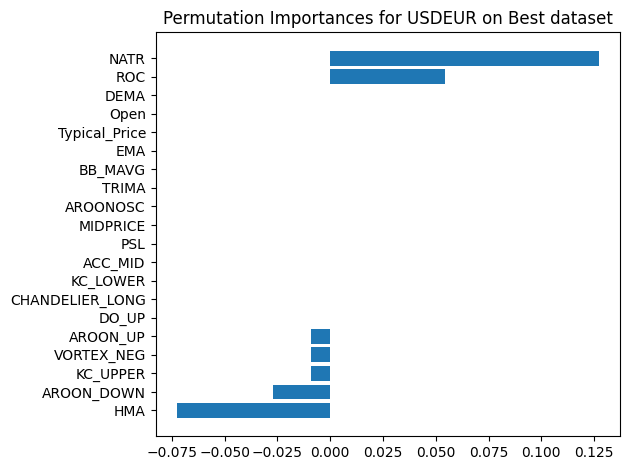

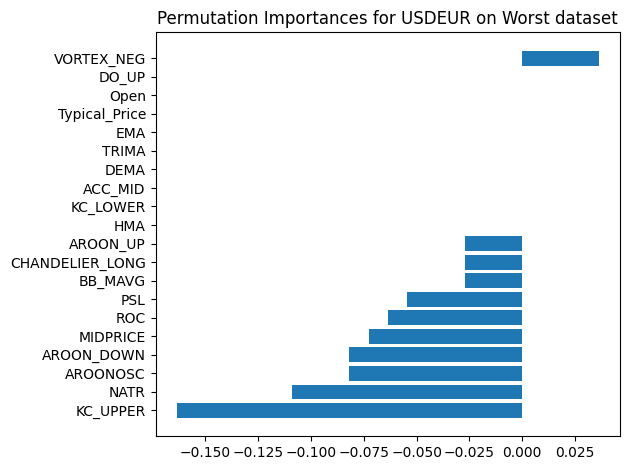

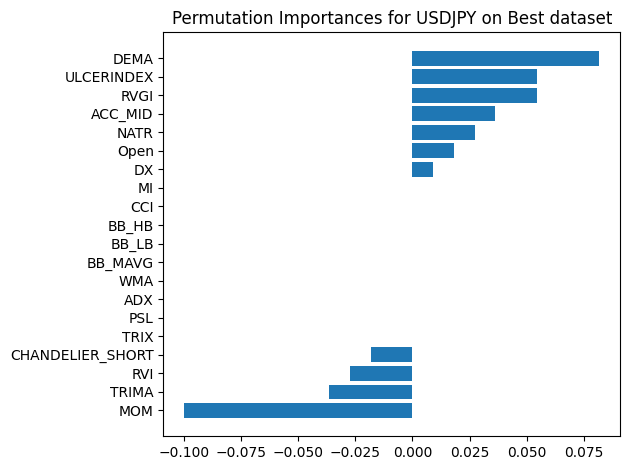

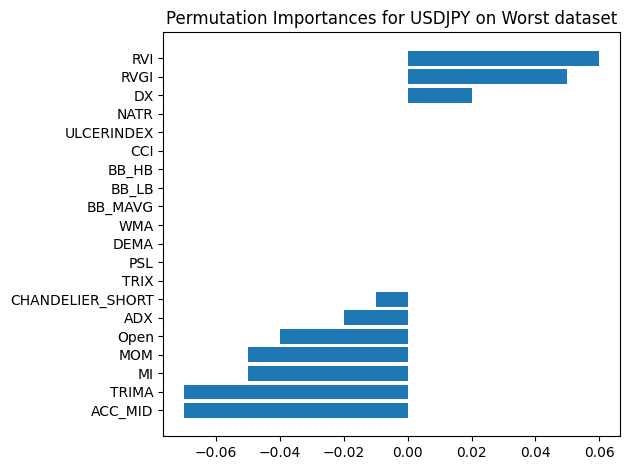

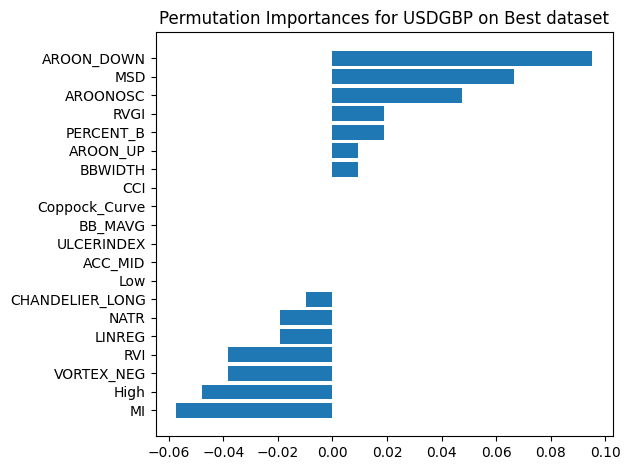

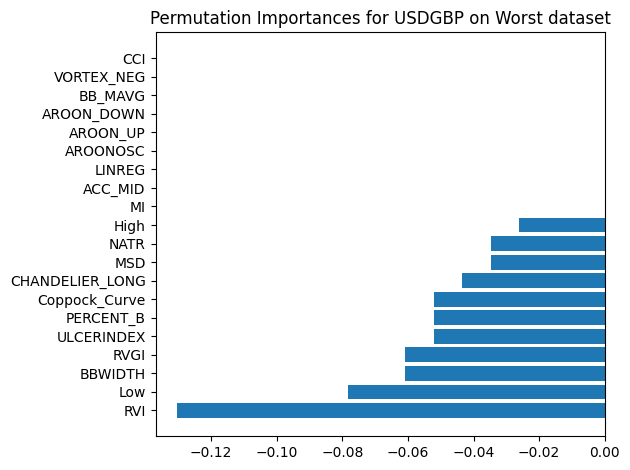

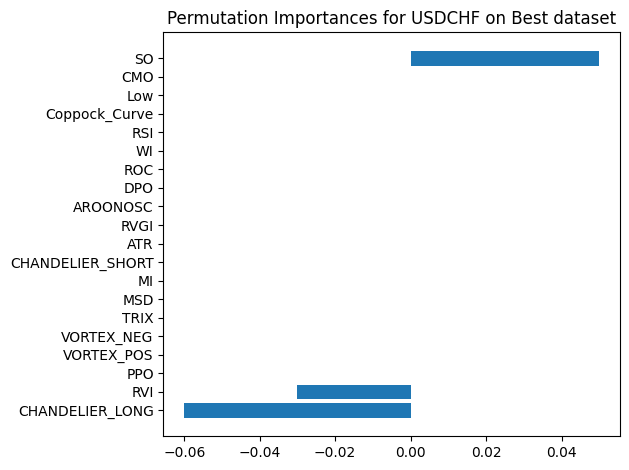

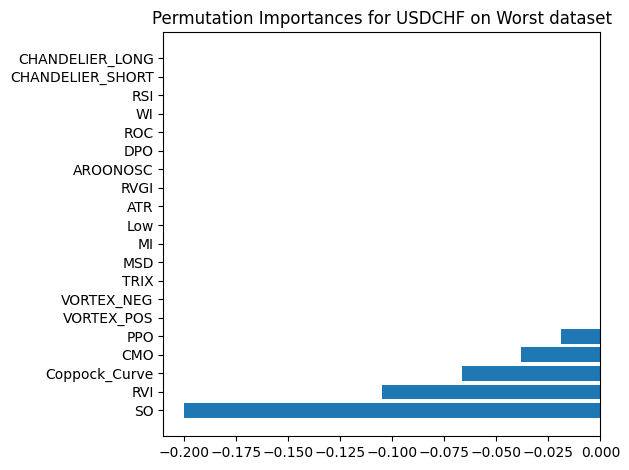

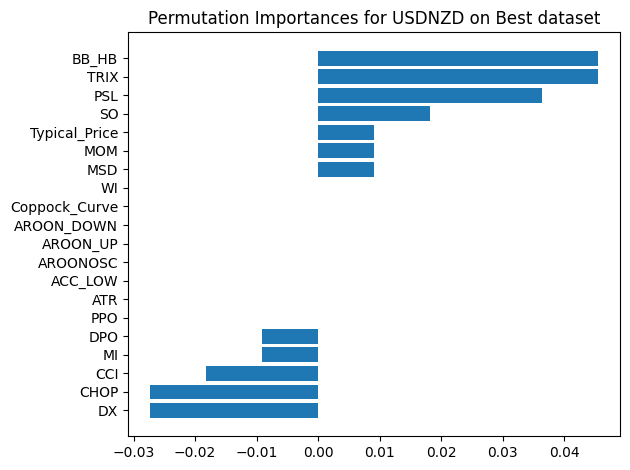

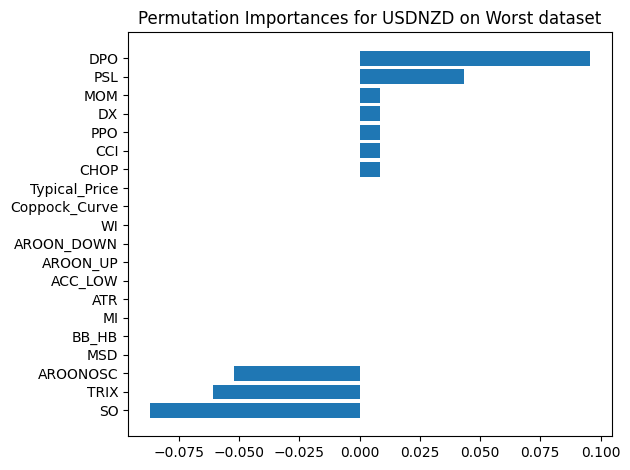

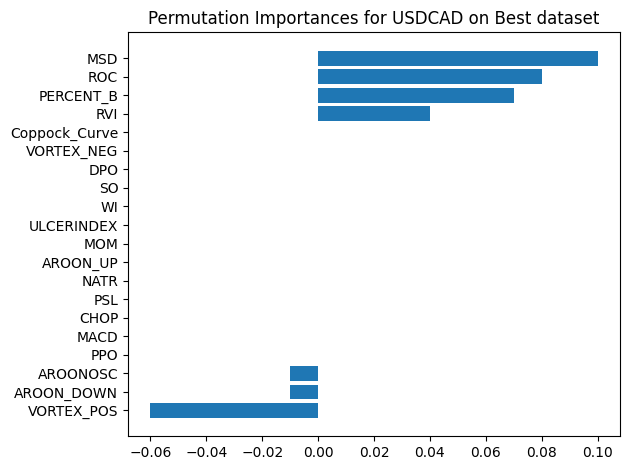

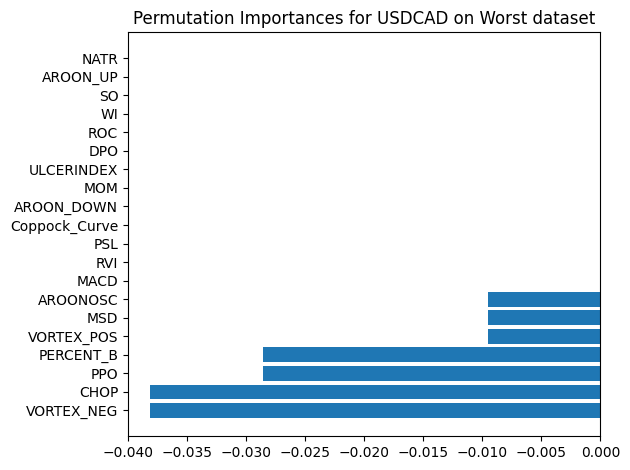

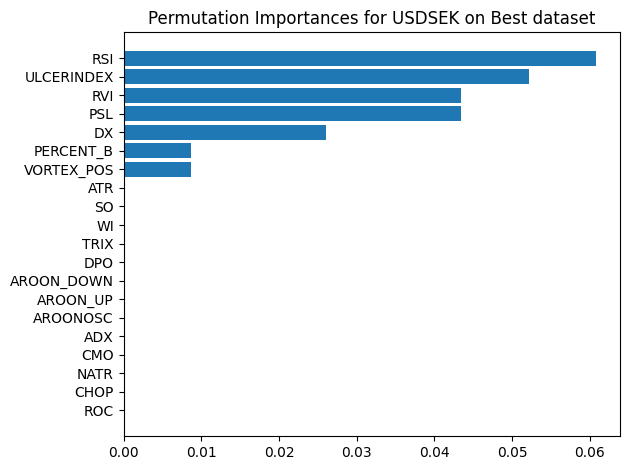

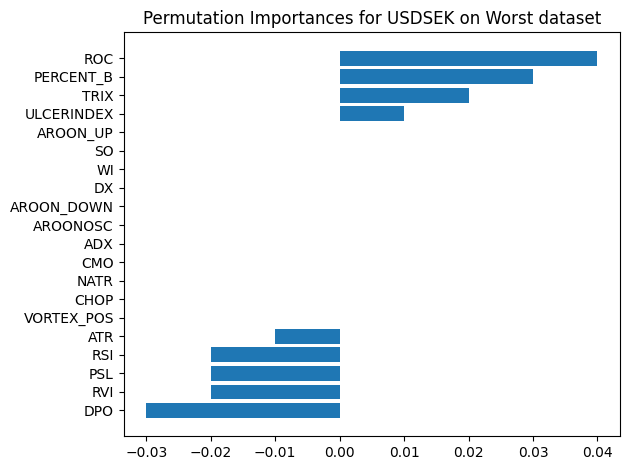

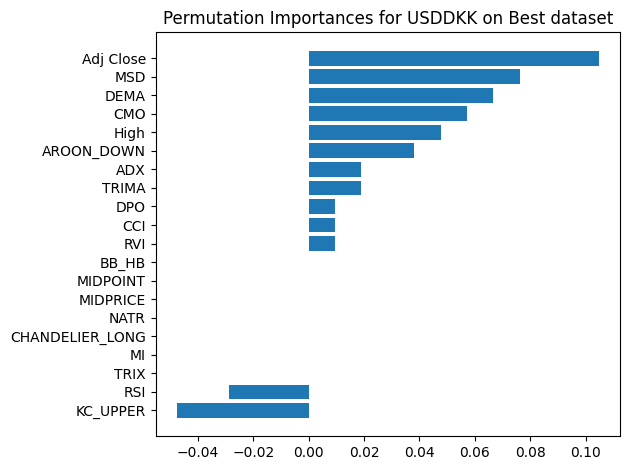

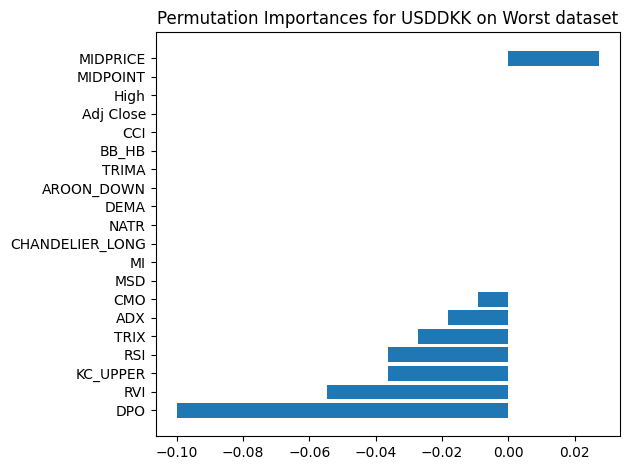

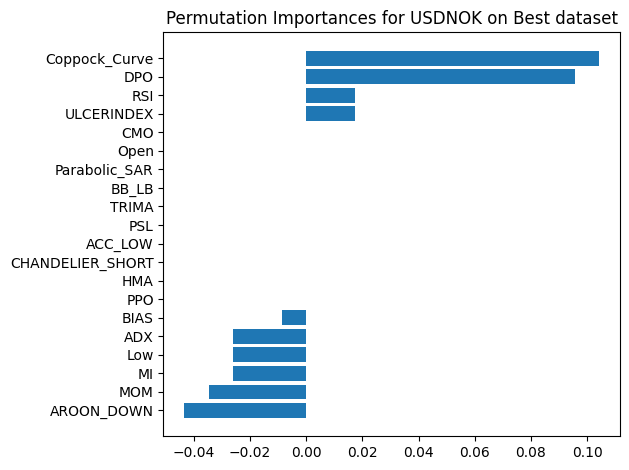

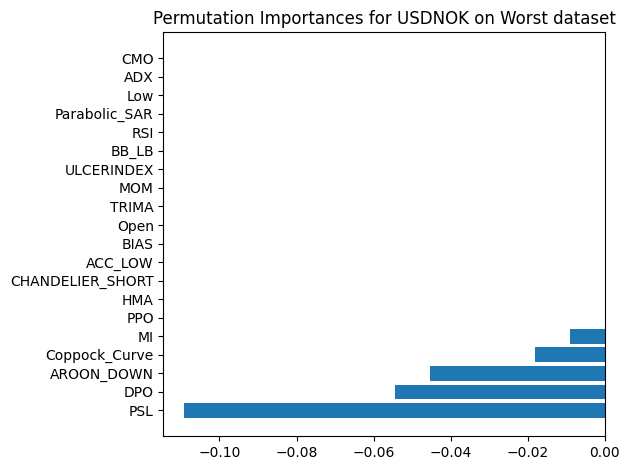

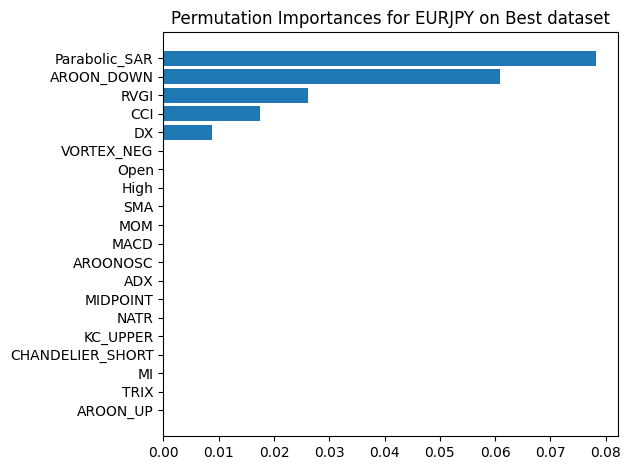

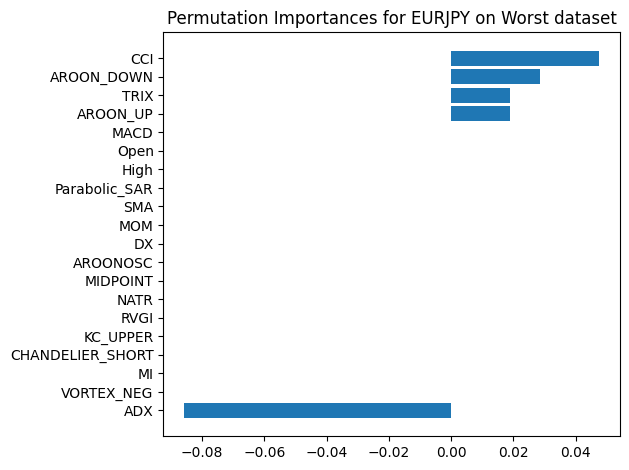

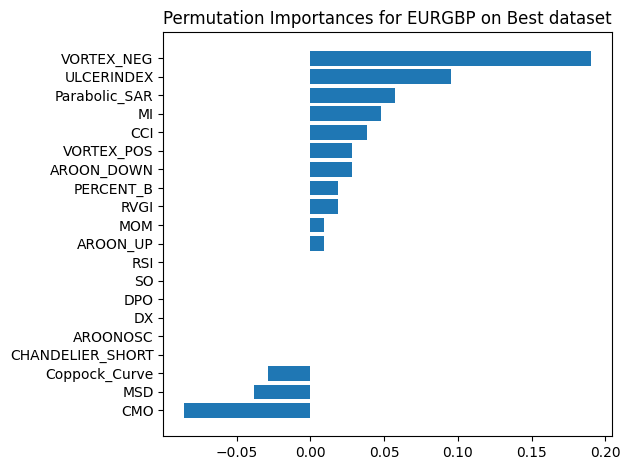

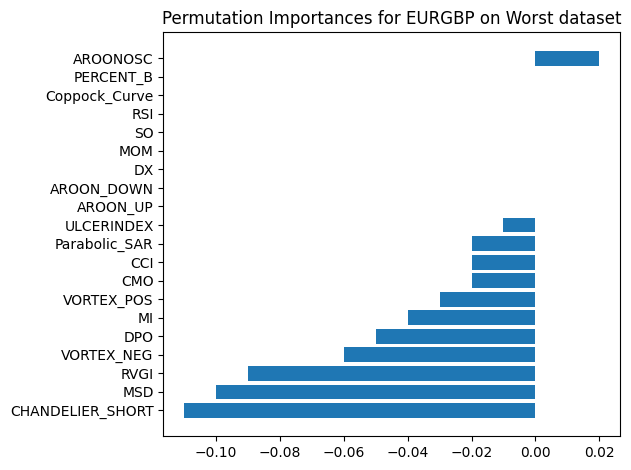

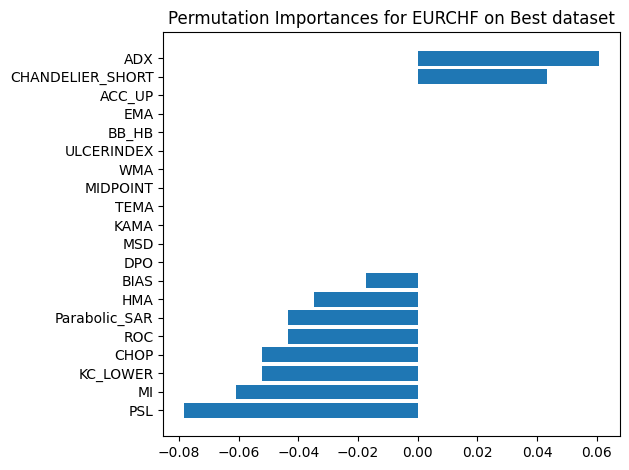

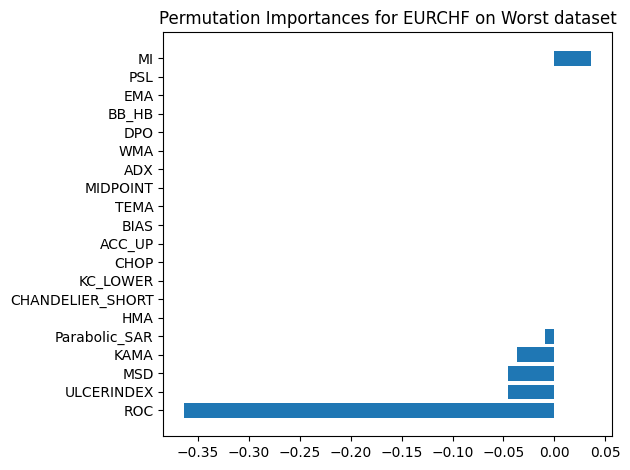

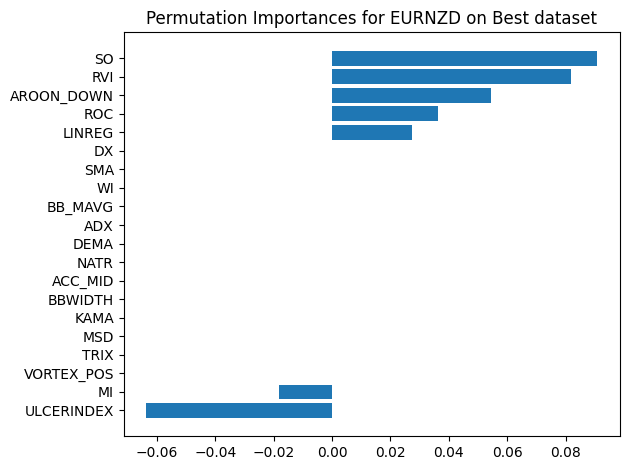

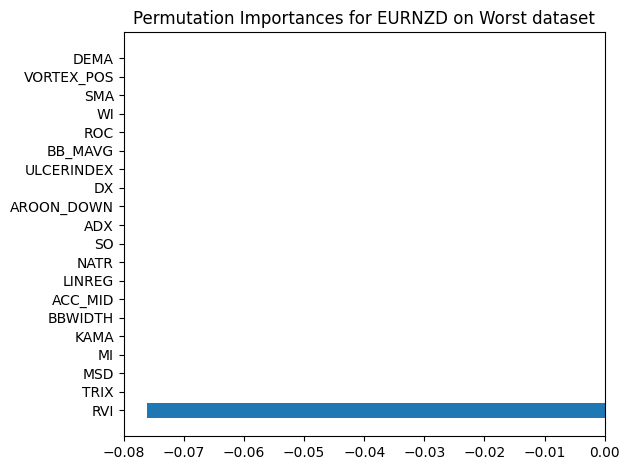

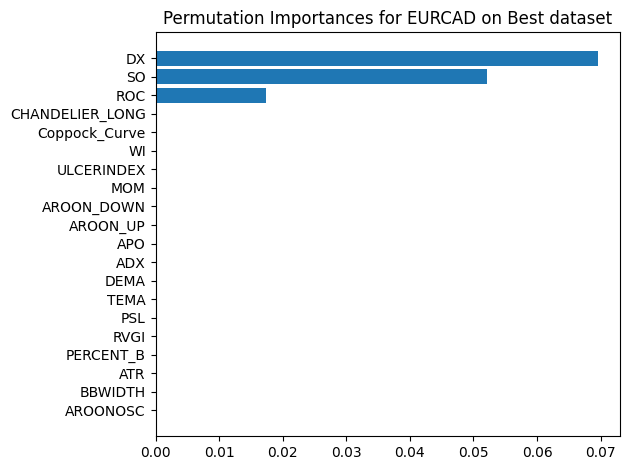

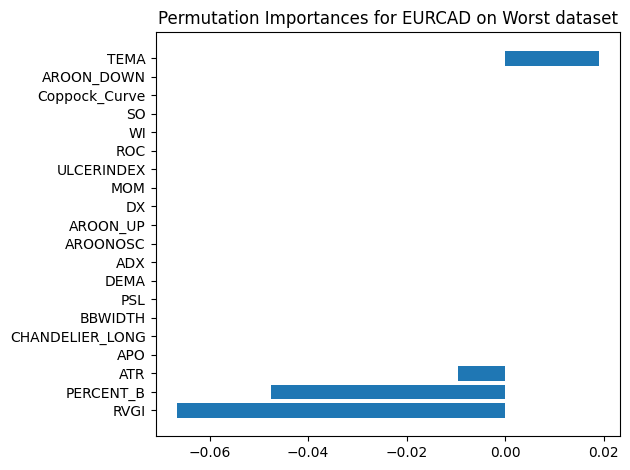

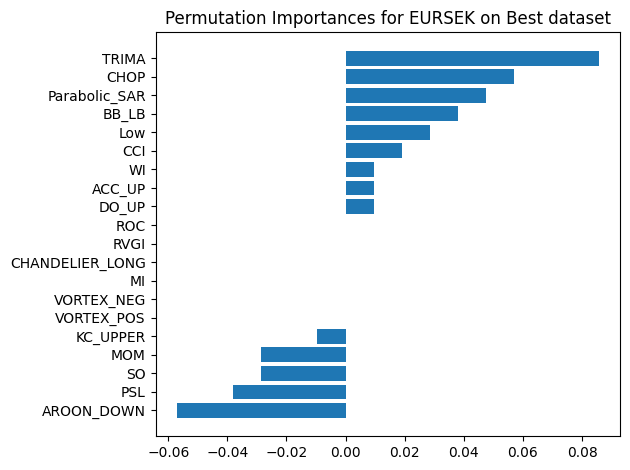

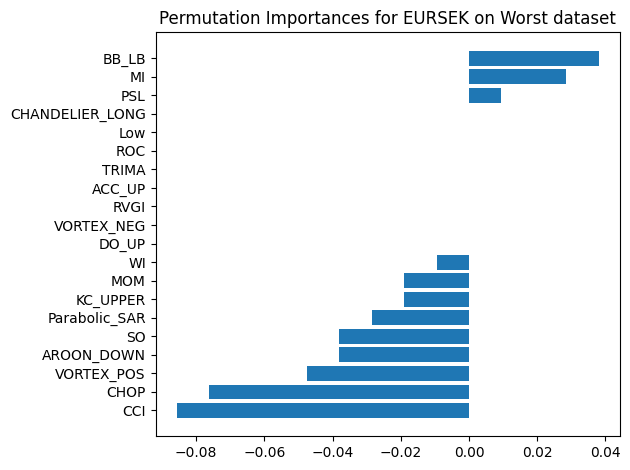

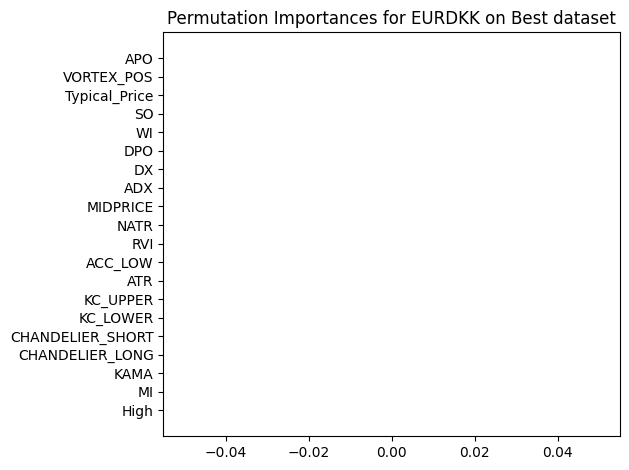

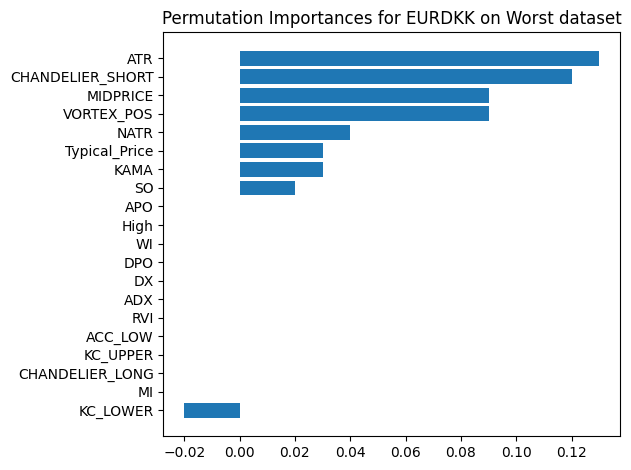

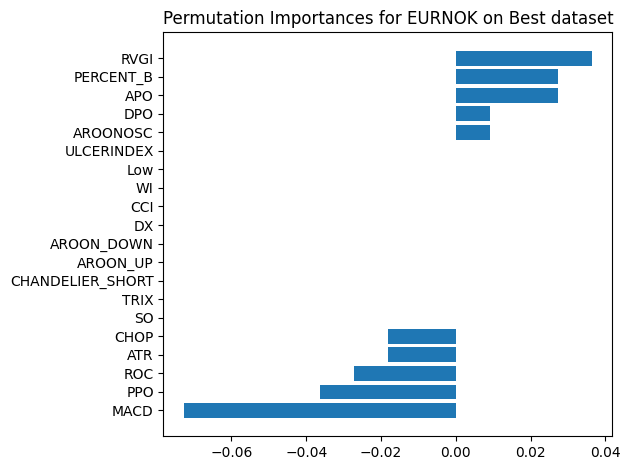

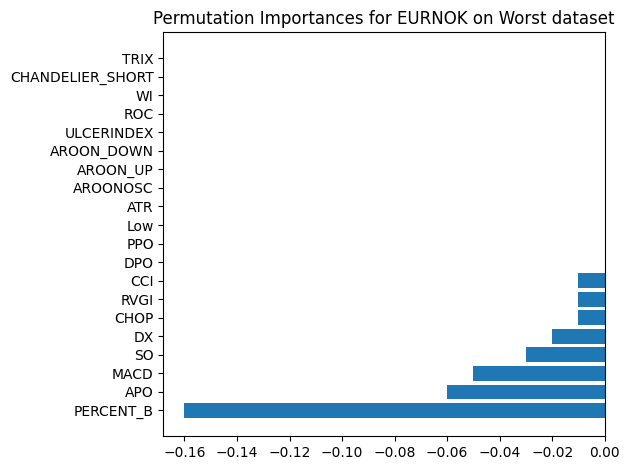

In [ ]:
# Plot the PFI scores
plot_pfi(PFI_Final)

In [ ]:
# Output path for saving the results in Excel format
output_path = path + '/Strategy_PFI_BnW_Month.xlsx'

# Prepare the writer to save data in Excel format
writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

# Convert and save the data in Excel sheets
for currency, datasets in PFI_Final.items():
    for dataset, pfi_values in datasets.items():
        # Consider only features with positive PFI values
        positive_pfi_values = [val for val in pfi_values if val[1] > 0]

        # If no feature has positive PFI value, store a placeholder message
        if not positive_pfi_values:
            df = pd.DataFrame([0], columns=["None features are important"], index=[dataset])
        else:
            # Convert the results into a DataFrame for saving
            df = pd.DataFrame(positive_pfi_values, columns=["Feature", "PFI"]).set_index("Feature").T

        # Save the data in a new sheet
        df.to_excel(writer, sheet_name=f"{currency}_{dataset}")
        
# Save the Excel file
writer.save()
